[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SDPM-lab/llm-lora-fine-tuning-course/blob/main/lyrics-llm-lora-demo.ipynb)




# 歌詞創作 AI - LoRA 微調實戰

## 學習目標
- 掌握 LLM 的 LoRA 微調流程
- 掌握訓練資料的準備作業
- 掌握 Token 處理作業
- 創建 Gradio Web UI 互動介面

## 歌詞創作特色
- **多元風格**：流行、民謠、搖滾、說唱等
- **情感豐富**：愛情、友情、勵志、懷舊等
- **結構完整**：主歌、副歌、橋段、結尾
- **押韻優美**：注重韻腳和節奏感

## 1. 環境設置與套件安裝

In [ ]:
# 安裝必要套件
!pip install -q torch transformers peft accelerate bitsandbytes gradio tqdm matplotlib

import os
import json
import torch
import gradio as gr
import numpy as np
from google.colab import userdata
from typing import Callable
from tqdm import tqdm
from datetime import datetime
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
)
from peft import (
    get_peft_model, 
    LoraConfig, 
    PeftModel,
    TaskType,
)
from torch.utils.data import Dataset, DataLoader

print("歌詞創作 AI 訓練環境")
print("=" * 40)
print("PyTorch 版本:", torch.__version__)
print("CUDA 可用:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU 記憶體:", f"{torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print("GPU 名稱:", torch.cuda.get_device_name(0))
print("Gradio 版本:", gr.__version__)

/home/wtlee4070s/miniconda3/envs/lora-fine-tune/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


歌詞創作 AI 訓練環境
PyTorch 版本: 2.7.1+cu126
CUDA 可用: True
GPU 記憶體: 11.7 GB
GPU 名稱: NVIDIA GeForce RTX 4070 SUPER
Gradio 版本: 5.38.1


## 2. 收集歌詞創作訓練數據

我們準備了 **20+ 首**不同風格和主題的歌詞，涵蓋：
- **流行情歌**：愛情主題
- **搖滾勵志**：奮鬥主題
- **民謠治癒**：溫暖主題
- **說唱節拍**：街頭文化
- **古風詩意**：中國風
- **爵士浪漫**：都市情調

In [2]:
# 豐富的歌詞創作訓練數據集
lyrics_training_data = [
    # 流行情歌類
    {
        "instruction": "寫一首關於初戀回憶的流行歌詞，要溫柔且感人",
        "output": """《初見時光》

[第一段]
那年夏天的午後
你穿著白色洋裝走過
陽光灑在你髮梢
我的心跳亂了節拍
青澀的話語說不出口
只能偷偷看著你笑

[副歌]
初見時光多美好
純真歲月不會老
雖然我們已分開
那份美好永遠在
初戀如花般綻放
在記憶深處閃閃發亮

[第二段]
操場邊的梧桐樹
見證我們的青春歲月
手牽手走過的路
現在只剩我一個人
翻開舊時的日記
淚水模糊了字跡

[橋段]
如果能重來一次
我會勇敢說愛你
不讓遺憾留心底
讓愛情有個美麗結局

[結尾]
初見時光多美好
那個夏天永難忘
謝謝你給我的美好
是我青春最珍貴的寶"""
    },
    {
        "instruction": "創作一首關於遠距離戀愛的深情歌詞",
        "output": """《千里之外》

[第一段]
城市的夜燈點亮
我望向你的方向
隔著千山萬水
思念如潮水般洶湧
手機裡的你笑得燦爛
螢幕卻觸碰不到溫暖

[副歌]
千里之外有個你
是我心中最美的風景
就算相隔天涯海角
愛意不會因距離而減少
等到重逢的那一天
我要緊緊把你擁抱

[第二段]
時差讓我們錯過
太多想說的話語
但每一次的通話
都讓心更加靠近
收藏你每條訊息
像收藏珍貴的寶石

[橋段]
雖然不能每天見面
但我們的心在一起
愛情不會因為距離
而失去它的魔力

[結尾]
千里之外有個你
是我前進的動力
愛情讓我們相信
距離只是暫時的分離"""
    },
    # 搖滾勵志類
    {
        "instruction": "寫一首充滿力量的搖滾勵志歌詞，主題是追求夢想",
        "output": """《不屈的心》

[第一段]
黑夜無法熄滅我的火焰
挫折無法打倒我的信念
就算全世界都說不可能
我依然要追逐我的夢
血液裡流淌著不屈的靈魂
心中有座不倒的高山

[副歌]
我有一顆不屈的心
再大的風雨都不怕
就算跌倒一千次
我會站起來一千零一次
夢想就是我的力量
讓我勇敢地向前闖

[第二段]
汗水和淚水交織成歌
每一滴都是奮鬥的印記
別人的嘲笑只是雜音
真正的勇士從不回頭
舞台就在前方等待
我要唱出自己的精彩

[橋段]
Rock and Roll精神在血管裡奔騰
自由的呼喊震撼天空
沒有什麼能阻擋我的腳步
因為我心中有不滅的火

[結尾]
不屈的心永遠年輕
夢想的路永不停息
Let's rock！讓我們搖滾！
用音樂點燃整個世界！"""
    },
    {
        "instruction": "創作一首關於克服困難的搖滾歌詞",
        "output": """《破繭成蝶》

[第一段]
被困在黑暗的繭中
感覺世界要把我吞沒
每一次的掙扎都是痛
但我不會選擇放棄
痛苦是成長的代價
我要用力量撕破束縛

[副歌]
我要破繭成蝶
飛向自由的天空
不再害怕風暴
因為我已經足夠強大
破繭成蝶的那一刻
就是我重生的時候

[第二段]
曾經的軟弱已成過去
現在的我無所畏懼
每一道傷疤都是勇氣的證明
每一次失敗都讓我更堅強
吉他的咆哮是我的戰歌
鼓點敲響勝利的節拍

[橋段]
變化是痛苦的
但不變是死亡的
我選擇痛苦地活著
也不要安逸地死去

[結尾]
看我破繭而出
展開美麗的翅膀
這就是重生的力量
這就是不死的搖滾精神！"""
    },
    # 民謠治癒類
    {
        "instruction": "寫一首溫暖治癒的民謠，主題是關於家的溫暖",
        "output": """《回家的路》

[第一段]
走過了多少條街
看過了多少風景
心中最美的還是
那條回家的小路
媽媽在廚房忙碌
爸爸在客廳看報
簡單的生活片段
卻是最珍貴的寶

[副歌]
家是永遠的港灣
不管我走多遠
那盞為我點亮的燈
指引我回家的方向
家人的愛如春風
溫暖我疲憊的心

[第二段]
外面的世界很大
我像蒲公英四處飄
但根永遠在家鄉的土地裡
那裡有我最初的夢
奶奶的搖椅還在搖
院子裡的桂花還在香

[橋段]
無論走到哪裡
我都是家人的孩子
無論多麼成功
家永遠是我的根

[結尾]
回家的路不會變
家人的愛不會變
那是我心中最溫暖的歌
永遠唱不完的歌"""
    },
    {
        "instruction": "創作一首關於友情陪伴的治癒民謠",
        "output": """《老朋友》

[第一段]
咖啡店裡的下午
我們坐在老位子
聊著天南海北的話題
時間彷彿停止
你的笑聲還是那樣
能治癒我所有的憂傷

[副歌]
老朋友，真好
歲月沒有讓我們疏離
雖然各自都在奔跑
心還是靠得很近
老朋友的溫暖
是這世界最美的禮物

[第二段]
想起我們一起的日子
青春歲月多美好
一起哭過一起笑過
一起做過的白日夢
現在我們都長大了
但友誼依然純真

[橋段]
謝謝你一直在
在我需要的時候
謝謝你的理解
讓我不再孤單

[結尾]
老朋友，老朋友
願我們都能好好的
友情這首歌
我們要一直唱下去"""
    },
    # 說唱節拍類
    {
        "instruction": "寫一首說唱歌詞，主題是關於城市生活的奮鬥",
        "output": """《城市叢林》

[Verse 1]
早上六點鬧鐘響起
又是一天的戰鬥開始
地鐵裡人潮擁擠
每個人都在追逐自己的夢想
辦公大樓像高聳的監獄
但我不會被困住
用說唱當作武器
在城市叢林裡闖出一條路

[Hook]
City life, city dreams
在鋼筋水泥中尋找自己
Hustle hard, never stop
直到成功站在頂峰
這是城市叢林的法則
適者生存弱者淘汰

[Verse 2]
夜晚的霓虹燈閃爍
照亮我前進的道路
街頭巷尾的故事
都寫進我的rap裡
從底層開始爬起
每一步都踏得很實
不靠關係不走捷徑
用實力證明自己

[Bridge]
這座城市不相信眼淚
只相信汗水和努力
每個人都有機會
關鍵看你敢不敢拼

[Outro]
From the bottom to the top
我的故事永不停
城市叢林見證我的成長
這就是我的hip-hop!"""
    },
    {
        "instruction": "創作一首關於青春回憶的說唱歌詞",
        "output": """《少年時代》

[Verse 1]
還記得那些年我們一起瘋
在球場上揮灑青春的汗
放學後的遊戲廳
週末的KTV
那時候的我們以為時間很多
以為友情會永遠不變
現在各自奔向不同的方向
但記憶永遠鮮活

[Hook]
少年時代不會再來
但那些回憶永遠精彩
We were young and free
沒有什麼好擔心
那是最美好的年代
無憂無慮的年代

[Verse 2]
初戀的酸甜苦辣
考試前的緊張焦慮
畢業典禮的眼淚
都是青春的印記
那時候覺得大人很煩
現在才知道他們的用心
那時候急著長大
現在想回到過去

[Bridge]
時光機如果真的存在
我想回到那個夏天
再過一次少年時代
再感受一次那份純真

[Outro]
Youth is gone but not forgotten
青春不老，回憶永恆
這就是我們的故事
這就是我們的青春rap!"""
    },
    # 古風詩意類
    {
        "instruction": "寫一首中國風古韻歌詞，主題是江南水鄉",
        "output": """《江南煙雨》

[第一段]
小橋流水繞人家
青石板路映晚霞
烟雨朦朧江南景
如詩如畫入我心
撐一把油紙傘
走過青磚白瓦間
聽雨滴答滴答響
彷彿古人在吟唱

[副歌]
江南好風光
最憶是春江
楊柳綠如煙
桃花紅似霞
一壺老酒醉斜陽
半卷詩書話流年

[第二段]
西湖邊柳絲飄揚
蘇堤上遊人如織
斷橋殘雪話淒美
雷峰塔下訴情長
烏篷船搖向遠方
漁歌晚唱起夕陽

[橋段]
千年古韻猶在
文人墨客留香
江南如一幅畫
永遠看不夠的美

[結尾]
江南煙雨夢中來
醒來已是客他鄉
何時能再回江南
重溫那段好時光"""
    },
    {
        "instruction": "創作一首關於古代俠客的中國風歌詞",
        "output": """《俠客行》

[第一段]
仗劍走天涯
快意江湖路
十步殺一人
千里不留名
白衣如雪劍如霜
俠骨柔情心如鐵
為國為民除暴安良
生死看淡義字當先

[副歌]
俠客不問出處
只看正義在心
刀光劍影中
守護蒼生安寧
縱橫天下無敵手
笑傲江湖真英雄

[第二段]
月下獨酌一壺酒
回想當年少年狂
師父教導猶在耳
俠之大者為國為民
雖有無數仇敵追殺
但俠義之心永不改

[橋段]
江湖險惡人心複雜
但總有人願意守護光明
這就是俠客的使命
這就是俠客的宿命

[結尾]
俠客行，俠客行
仗劍天涯永不停
只要人間有不平
俠客精神永流傳"""
    },
    # 爵士浪漫類
    {
        "instruction": "寫一首爵士風格的浪漫歌詞，場景是午夜的城市",
        "output": """《午夜藍調》

[第一段]
午夜的城市燈火闌珊
爵士酒吧裡薩克斯風輕響
你坐在吧台邊淺酌紅酒
美得像幅油畫
鋼琴師彈著藍調
訴說著夜的故事
而我只想靠近你
在這個迷人的夜晚

[副歌]
Midnight blues
讓我為你唱一首歌
City lights
見證我們的邂逅
在這個充滿爵士樂的夜晚
讓我們慢慢相愛

[第二段]
你的眼神如星光般閃爍
在霓虹燈的映襯下
顯得格外迷人
低音提琴的旋律
像你走路的節拍
優雅而充滿誘惑

[橋段]
Dance with me under the moonlight
在月光下與我共舞
Let the jazz music guide our hearts
讓爵士樂指引我們的心

[結尾]
午夜藍調還在繼續
但我已經愛上了你
This is our midnight story
這是我們的午夜故事"""
    },
    # 更多流行情歌
    {
        "instruction": "創作一首關於失戀後重新開始的勵志情歌",
        "output": """《重新開始》

[第一段]
收拾好破碎的心情
把眼淚擦乾淨
雖然你已經離開
但我要繼續前進
愛情不是生命的全部
我還有很多夢想要完成
感謝你給我的回憶
現在我要學會放手

[副歌]
我要重新開始
重新愛自己
不再為了誰而哭泣
不再為了誰而迷失
重新開始的我
會變得更加美麗

[第二段]
刪掉所有你的照片
收起所有的回憶
不是因為不愛了
而是學會了愛自己
世界還是很美好
太陽依然會升起

[橋段]
感謝那段美好的時光
教會我如何去愛
現在我要用這份愛
好好愛自己

[結尾]
重新開始不是結束
而是另一個開始
我相信未來會更好
因為我已經學會堅強"""
    },
    {
        "instruction": "寫一首關於母親節的感恩歌詞",
        "output": """《媽媽的愛》

[第一段]
小時候總是不懂事
讓媽媽為我操碎心
深夜裡她為我蓋被子
生病時她徹夜不眠
那雙粗糙的手
為我做過多少事
那溫暖的懷抱
是我最安全的港灣

[副歌]
媽媽的愛像海一樣深
包容我所有的任性
媽媽的愛像山一樣高
給我無窮的力量
謝謝您給了我生命
謝謝您給了我愛

[第二段]
長大後才明白
媽媽有多不容易
為了我她放棄了夢想
把所有的愛都給了我
現在她頭髮白了
臉上皺紋多了
但在我心中
她永遠最美

[橋段]
現在換我來愛您
用我全部的心
就像您愛我一樣
無私而深沉

[結尾]
媽媽我愛您
這輩子都不會變
您是我最重要的人
我永遠的媽媽"""
    },
    # 更多搖滾勵志
    {
        "instruction": "創作一首關於青年創業奮鬥的搖滾歌詞",
        "output": """《創業者之歌》

[第一段]
背著背包走出校門
心中燃燒著創業夢
沒有資金沒有人脈
只有滿腔的熱血
在小小的車庫裡
開始我的第一步
雖然條件很艱苦
但夢想讓我堅強

[副歌]
我是創業者
不怕失敗不怕累
就算跌倒了
也要爬起來繼續飛
改變世界的夢想
在我心中燃燒

[第二段]
熬夜寫代碼
喝咖啡當晚餐
為了一個bug
可以廢寢忘食
投資人的拒絕
不能澆滅我的火
用戶的認可
是最大的獎勵

[橋段]
Every failure is a lesson
每次失敗都是學習
Every setback makes us stronger
每次挫折讓我們更強

[結尾]
創業路上不孤單
因為有夢想相伴
總有一天我們會成功
用行動證明青春無敵！"""
    },
    # 更多民謠治癒
    {
        "instruction": "寫一首關於四季變化的溫暖民謠",
        "output": """《四季歌》

[第一段 - 春天]
春天來了花兒開
萬物復甦大地綠
燕子從南方飛回來
帶來溫暖的消息
我們脫下厚重的外套
感受春風的溫柔

[第二段 - 夏天]
夏天的陽光熱情如火
蟬鳴聲聲入耳來
冰鎮西瓜甜如蜜
夏夜晚風輕輕吹
和朋友一起看星星
許下夏日的心願

[第三段 - 秋天]
秋天的葉子黃了
豐收的季節到了
桂花香飄千里外
月餅圓圓人團圓
穿上溫暖的毛衣
感受秋日的詩意

[第四段 - 冬天]
冬天雪花飄飄
世界變成白色童話
圍爐取暖話家常
一年又要過去了
感謝四季的陪伴
期待來年更美好

[副歌]
四季輪迴永不停
每個季節都美麗
就像人生的路
有起有落才完整
感謝時光的禮物
感謝生命的奇跡

[結尾]
春夏秋冬我都愛
因為每個季節
都有它獨特的美
都值得我們珍惜"""
    },
    # 更多說唱風格
    {
        "instruction": "創作一首關於網絡時代的說唱歌詞",
        "output": """《Digital Age》

[Verse 1]
Wake up check my phone第一件事
社交媒體上的消息不停
點讚評論轉發分享
虛擬世界裡找存在感
WiFi斷了像斷了翅膀
5G時代速度飛快
但有時候我也想
回到沒有手機的年代

[Hook]
Digital age we're living in
數字時代改變一切
Connect the world but disconnect ourselves
連接世界卻失去自己
This is the reality
這就是現實

[Verse 2]
線上購物線上學習
線上工作線上社交
AI人工智能崛起
機器人開始思考
大數據分析我們的行為
演算法決定我們看什麼
隱私在透明的世界裡
變得越來越珍貴

[Bridge]
Technology is a double-edged sword
科技是把雙刃劍
We need to learn how to use it right
我們需要學會正確使用

[Outro]
Digital natives that's what we are
我們是數字原住民
But don't forget the human heart
但別忘了人類的心
在這個數位時代裡
保持人性最重要！"""
    },
    # 更多古風詩意
    {
        "instruction": "寫一首關於古代書生求學的中國風歌詞",
        "output": """《書生吟》

[第一段]
十年寒窗苦讀書
只為一朝登金榜
青燈黃卷伴長夜
詩書滿腹志高遠
梅花香自苦寒來
寶劍鋒從磨礪出
雖然前路多坎坷
書生意氣不能改

[副歌]
書中自有黃金屋
書中自有顏如玉
但求學而時習之
不亦說乎不亦樂乎
修身齊家治國平天下
這是書生的抱負

[第二段]
春風得意馬蹄疾
一日看盡長安花
金榜題名時
喜悅如潮湧
但更重要的是
學以致用濟蒼生
不負寒窗苦讀時
不負聖賢教誨恩

[橋段]
學而不思則罔
思而不學則殆
知之為知之
不知為不知

[結尾]
書生意氣永不老
學無止境路漫漫
縱然白髮滿頭
求學之心不變"""
    },
    # 更多爵士浪漫
    {
        "instruction": "創作一首關於咖啡店邂逅的爵士風格歌詞",
        "output": """《咖啡店的邂逅》

[第一段]
Sunday morning coffee shop
陽光透過百葉窗
你坐在角落的位置
專注地看著書
拿鐵的香氣瀰漫
混合著你的香水味
爵士樂輕柔地播放
這畫面太完美

[副歌]
Coffee shop romance
咖啡店裡的浪漫
Slow jazz and your smile
慢爵士和你的笑容
This moment feels so right
這一刻如此美好
I want to make you mine
我想讓你屬於我

[第二段]
你抬頭看向我的方向
我們的眼神相遇
時間彷彿靜止了
只有心跳的節拍
我走向你的座位
鼓起勇氣說了聲Hi
你的笑容如陽光
溫暖了整個咖啡店

[橋段]
Maybe this is destiny
也許這就是命運
Maybe this is love at first sight
也許這就是一見鍾情

[結尾]
咖啡店的邂逅
是我們愛情的開始
Jazz music plays on
爵士樂繼續播放著
But now we have our own song
但現在我們有了自己的歌"""
    }
]

print(f"歌詞創作數據準備完成！")
print(f"總樣本數: {len(lyrics_training_data)}")
print(f"流行情歌: {len([d for d in lyrics_training_data if '流行' in d['instruction'] or '情歌' in d['instruction'] or '失戀' in d['instruction'] or '母親' in d['instruction']])} 首")
print(f"搖滾勵志: {len([d for d in lyrics_training_data if '搖滾' in d['instruction'] or '勵志' in d['instruction'] or '創業' in d['instruction']])} 首")
print(f"民謠治癒: {len([d for d in lyrics_training_data if '民謠' in d['instruction'] or '治癒' in d['instruction'] or '四季' in d['instruction']])} 首")
print(f"說唱節拍: {len([d for d in lyrics_training_data if '說唱' in d['instruction'] or 'rap' in d['instruction'].lower() or '網絡' in d['instruction']])} 首")
print(f"古風詩意: {len([d for d in lyrics_training_data if '中國風' in d['instruction'] or '古' in d['instruction'] or '書生' in d['instruction']])} 首")
print(f"爵士浪漫: {len([d for d in lyrics_training_data if '爵士' in d['instruction'] or '咖啡店' in d['instruction']])} 首")

# 顯示一個樣本
print("\n樣本預覽 - 流行情歌:")
print("="*60)
sample = lyrics_training_data[0]
print(f"指令: {sample['instruction']}")
print(f"歌詞:\n{sample['output'][:300]}...")
print("="*60)

歌詞創作數據準備完成！
總樣本數: 18
流行情歌: 4 首
搖滾勵志: 4 首
民謠治癒: 3 首
說唱節拍: 3 首
古風詩意: 3 首
爵士浪漫: 2 首

樣本預覽 - 流行情歌:
指令: 寫一首關於初戀回憶的流行歌詞，要溫柔且感人
歌詞:
《初見時光》

[第一段]
那年夏天的午後
你穿著白色洋裝走過
陽光灑在你髮梢
我的心跳亂了節拍
青澀的話語說不出口
只能偷偷看著你笑

[副歌]
初見時光多美好
純真歲月不會老
雖然我們已分開
那份美好永遠在
初戀如花般綻放
在記憶深處閃閃發亮

[第二段]
操場邊的梧桐樹
見證我們的青春歲月
手牽手走過的路
現在只剩我一個人
翻開舊時的日記
淚水模糊了字跡

[橋段]
如果能重來一次
我會勇敢說愛你
不讓遺憾留心底
讓愛情有個美麗結局

[結尾]
初見時光多美好
那個夏天永難忘
謝謝你給我的美好
是我青春最珍貴的寶...


## 3. 從 Huggingface 下載基底模型

In [ ]:
!huggingface-cli login --token {userdata.get("HF_TOKEN")}

SAVE_PATH="hf_models/gemma-3-1b-it"
MODEL_NAME="google/gemma-3-1b-it"
!huggingface-cli download {MODEL_NAME} --local-dir {SAVE_PATH}

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `huggingface-cli login --token <user_huggingface_token>'
Fetching 10 files: 100%|█████████████████████| 10/10 [00:00<00:00, 19887.64it/s]
/home/wtlee4070s/llm-lora-fine-tuning-course/hf_models/gemma-3-1b-it


## 4. 載入模型和分詞器

In [4]:
# 模型配置
MODEL_PATH = SAVE_PATH
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"開始載入歌詞創作模型: {MODEL_PATH}")
print(f"使用設備: {device}")

# 載入分詞器
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, padding_side="right")

# 設置 pad_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"分詞器載入完成，詞彙量: {len(tokenizer):,}")

# 載入模型
model_kwargs = {
    "torch_dtype": torch.float16 if device == "cuda" else torch.float32,
    "device_map": "cuda:0" if device == "cuda" else None,
    # "device_map": "auto" if device == "cuda" else None,
}
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, **model_kwargs)
print(f"模型載入完成！")
print(f"總參數量: {model.num_parameters():,}")

開始載入歌詞創作模型: hf_models/gemma-3-1b-it
使用設備: cuda
分詞器載入完成，詞彙量: 262,145
模型載入完成！
總參數量: 999,885,952


## 5. 設置歌詞創作專用 LoRA 配置

In [5]:
# 歌詞創作專用 LoRA 配置
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,  # 適中的秩數，平衡創意和控制
    lora_alpha=16,  # 較高的 alpha 值，增強學習效果
    lora_dropout=0.1,  # 較低的 dropout，保持創意流暢性
    target_modules=[
        "q_proj", "v_proj"  # 要微調的注意力層 "q_proj", "k_proj", "v_proj"
    ],
    bias="none",
)

# 創建歌詞創作 PEFT 模型
peft_model = get_peft_model(model, lora_config)

# 計算參數統計
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in peft_model.parameters())

print("歌詞創作 LoRA 配置完成！")
print("=" * 50)
print(f"專用配置特點:")
print(f"   • 秩數 (r): {lora_config.r} - 平衡創意和控制")
print(f"   • Alpha: {lora_config.lora_alpha} - 增強學習效果")
print(f"   • Dropout: {lora_config.lora_dropout} - 保持創意流暢")
print(f"   • 目標模組: 注意力")
print(f"\n參數統計:")
print(f"   • 總參數: {total_params:,}")
print(f"   • 可訓練參數: {trainable_params:,}")
print(f"   • 可訓練比例: {100 * trainable_params / total_params:.3f}%")

# 詳細參數信息
peft_model.print_trainable_parameters()

歌詞創作 LoRA 配置完成！
專用配置特點:
   • 秩數 (r): 8 - 平衡創意和控制
   • Alpha: 16 - 增強學習效果
   • Dropout: 0.1 - 保持創意流暢
   • 目標模組: 注意力

參數統計:
   • 總參數: 1,000,631,424
   • 可訓練參數: 745,472
   • 可訓練比例: 0.075%
trainable params: 745,472 || all params: 1,000,631,424 || trainable%: 0.0745


## 6. 在訓練前，先測試看看模型的作曲能力

In [ ]:
def test_generate_lyrics(generate_lyrics_callback: Callable[[str], str]) -> str:
    # 多樣化的測試主題
    prompts = [
        "創作一首關於宇宙探索的科幻風格歌詞",
        "寫一首關於程式設計師的幽默搖滾歌詞",
        "創作一首關於童年回憶的溫暖民謠",
        # "寫一首關於學習AI的勵志說唱歌詞",
        # "創作一首關於深夜加班的爵士風格歌詞",
        # "寫一首關於環保主題的流行歌詞"
    ]

    print("\n開始測試歌詞生成...")
    result = []
    for i, prompt in enumerate(prompts, 1):
        print(f"\n測試 {i}: {prompt}")
        print("-" * 70)
        lyrics = generate_lyrics_callback(prompt)
        result.append((prompt, lyrics))
        print(f"生成歌詞:\n{lyrics}")
        print("-" * 70)
        
        if i < len(prompts):
            print("生成下一首歌詞...")

    print("\n歌詞創作 AI 測試完成！")

def generate_lyrics(model: PeftModel, tokenizer: AutoTokenizer, prompt: str) -> str:
    """生成歌詞的核心函數"""
    # 格式化輸入
    formatted_prompt = f"<bos><start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    
    # 分詞
    inputs = tokenizer(
        formatted_prompt,
        return_tensors="pt",
    ).to(model.device)
    
    # 生成歌詞
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            temperature=0.8,
            top_p=0.9,
            top_k=50,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_length=256 + 128,  # 最大生成長度
        )
    
    # 解碼並提取歌詞
    generated_text = tokenizer.decode(outputs[0])
    
    # 提取模型生成的部分
    if "<start_of_turn>model" in generated_text:
        lyrics = generated_text.split("<start_of_turn>model")[-1].strip()
        if "<end_of_turn>" in lyrics:
            lyrics = lyrics.split("<end_of_turn>")[0].strip()
        return lyrics
    else:
        return generated_text

# 測試生成歌詞功能
test_generate_lyrics(lambda prompt: generate_lyrics(peft_model, tokenizer, prompt))


開始測試歌詞生成...

測試 1: 創作一首關於宇宙探索的科幻風格歌詞
----------------------------------------------------------------------
生成歌詞:
好的，這是一首關於宇宙探索的科幻風格歌詞：

（Intro - 鋼琴聲，低沉而充滿希望）

星塵舞動，無垠之海，
迴響低語，寂靜無盡。
人類心靈，渴望著遠方，
探尋起源，尋找新篇章。

（Verse 1）
舷窗凝視，冰冷的星光，
一艘號稱「奧德賽」，引擎低鳴。
穿梭星雲，如夢似幻境，
數據編織，記錄著未知。
我們是孤獨的，在宇宙中，
尋找生命的痕跡，解開謎題。

（Pre-Chorus）
時間扭曲，重力崩塌，
未知生物，在星系中。
迴聲震顫，來自過去的記憶，
我們的心，將迎向新的方向。

（Chorus - 鼓聲加入，強烈有力）
宇宙之旅，無盡的呼喚，
探索者，打破束縛，勇敢向前。
星辰與黑洞，交織成舞曲，
尋找真理，與萬物共舞。

（Verse 2）
行星倒影，彩虹般的奇景，
外星文明，留下的殘留。
語言不通，文化異樣，
卻在溝通，彼此理解。
我們發現，生命的奇蹟，
在星系中，綻放光芒。

（Pre-Chorus）
時間扭曲，重力崩塌，
未知生物，在星系中。
迴聲震顫，來自過去的記憶，
我們的心，將迎向新的方向。
----------------------------------------------------------------------
生成下一首歌詞...

測試 2: 寫一首關於程式設計師的幽默搖滾歌詞
----------------------------------------------------------------------
生成歌詞:
好的，這是一首關於程式設計師的幽默搖滾歌詞：

(Intro - 鼓點、合成器和輕快的人聲)

(Verse 1)
我叫Steve，我只會用文字和碼
用咖啡和熱情，解決問題的行列
凌晨三點，我進入碼的迷宮
要編寫程式，讓世界不再迷惘

(Pre-Chorus)
別說夢想，別說星光，我只想搞清楚
一個迴圈，一個函數，再給它一個定義
(加強鼓點)

(Chorus - 尖銳的吉他 riff 和貝斯線)
我是程式設計師，是數字的舞者
用邏輯和算法，創造無限的樂章
Bug 總

## 7. 訓練歌詞數據預處理

In [7]:
class LyricsDataset(Dataset):
    def __init__(self, input_texts: list[str], tokenizer: AutoTokenizer):
        super().__init__()
        self.input_texts = input_texts
        self.tokenizer = tokenizer
        self.dataset = []
        
        for text in input_texts:
            # 分詞處理
            tokenized = tokenizer(
                text,
                truncation=True,
                padding="max_length",
                max_length=256 + 128, # 384
                return_tensors="pt",
            )
            self.dataset.append({
                "input_ids": tokenized["input_ids"].squeeze(0),
                "attention_mask": tokenized["attention_mask"].squeeze(0),
                "labels": tokenized["input_ids"],
            })

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]
    

def format_lyrics_data(data_list: list[dict]) -> list[str]:
    """將歌詞數據格式化為 Gemma 指令格式"""
    formatted_texts = []
    
    for item in data_list:
        # 使用 Gemma 的指令格式，專門針對歌詞創作
        formatted_text = f"<bos><start_of_turn>user\n{item['instruction']}<end_of_turn>\n<start_of_turn>model\n{item['output']}<end_of_turn><eos>"
        formatted_texts.append(formatted_text)
    
    return formatted_texts

# 格式化歌詞數據
import random
random.shuffle(lyrics_training_data) 
formatted_lyrics = format_lyrics_data(lyrics_training_data)

# 分割訓練和驗證數據 (85/15，更多訓練數據)
train_size = int(0.85 * len(formatted_lyrics))
train_texts = formatted_lyrics[:train_size]
eval_texts = formatted_lyrics[train_size:]

print(f"歌詞數據預處理完成")
print(f"訓練樣本: {len(train_texts)} 首歌詞")
print(f"驗證樣本: {len(eval_texts)} 首歌詞")


# 創建數據集
print("\n開始歌詞分詞處理...")
train_dataset = LyricsDataset(train_texts, tokenizer)
eval_dataset = LyricsDataset(eval_texts, tokenizer)
print("歌詞數據預處理完成！")


# 分析歌詞長度分佈
lengths = [len(tokenizer.tokenize(text)) for text in train_texts]
avg_length = sum(lengths) / len(lengths)
max_length = max(lengths)
min_length = min(lengths)

print(f"\n歌詞長度統計:")
print(f"  • 平均長度: {avg_length:.0f} tokens")
print(f"  • 最長歌詞: {max_length} tokens")
print(f"  • 最短歌詞: {min_length} tokens")

歌詞數據預處理完成
訓練樣本: 15 首歌詞
驗證樣本: 3 首歌詞

開始歌詞分詞處理...
歌詞數據預處理完成！

歌詞長度統計:
  • 平均長度: 244 tokens
  • 最長歌詞: 285 tokens
  • 最短歌詞: 205 tokens


## 8. 訓練與評估函式設計

In [8]:

def train_one_epoch(model: PeftModel, train_loader: DataLoader, optimizer: torch.optim.Optimizer, gradient_accumulation_steps: int) -> float:
    model.train()
    total_loss = 0.0
    count, step = 0, 0
    optimizer.zero_grad() # 初始化梯度
    
    loop = tqdm(train_loader, desc="Training")
    for batch in loop:
        step += 1
        # 將數據移動到模型所在設備
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        # 前向傳播計算損失
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        # 梯度累積
        if step % gradient_accumulation_steps == 0:
            optimizer.step()  # 更新權重
            optimizer.zero_grad()  # 重置梯度

        total_loss += loss.item()
        count += len(labels)
        avg_loss = total_loss / count
        loop.set_postfix(loss=f"{avg_loss:.4f}")
        
    optimizer.step()  # 更新權重
    optimizer.zero_grad()  # 重置梯度  
    
    return total_loss / count


def eval(model: PeftModel, eval_loader: DataLoader) -> float:
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        loop = tqdm(eval_loader, desc=f"Evaluating")
        for batch in loop:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["labels"].to(model.device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_loss += loss.item()
            count += len(labels)
            avg_loss = total_loss / count
            loop.set_postfix(loss=f"{avg_loss:.4f}")
    
    return total_loss / count


def train(
    model: PeftModel, 
    train_loader: DataLoader, 
    eval_loader: DataLoader, 
    lr: float,
    epochs: int,
    gradient_accumulation_steps: int,
) -> list[dict]:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    history = []
    for epoch in range(epochs):
        print(f"Training Epoch {epoch+1}/{epochs}")
        
        # 訓練一個 epoch
        train_start_time = datetime.now()
        train_loss = train_one_epoch(model, train_loader, optimizer, gradient_accumulation_steps)
        train_end_time = datetime.now()
        
        # 評估當前模型
        eval_start_time = datetime.now()
        eval_loss = eval(model, eval_loader)
        eval_end_time = datetime.now()
        
        history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "train_time": (train_end_time - train_start_time).total_seconds(),
            "eval_time": (eval_end_time - eval_start_time).total_seconds(),
        })
        print()
        
    return history
        

## 9. 開始歌詞創作模型訓練！

歌詞訓練配置:
  • 訓練輪數: 32
  • 學習率: 5e-05
  • 批次大小: 3
  • 梯度累積: 2 步
  • 有效批次: 6
開始歌詞創作 AI 訓練...
訓練開始時間: 2025-07-24 08:08:48
Training Epoch 1/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s, loss=4.4984]



Training Epoch 2/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, loss=4.1905]



Training Epoch 3/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, loss=3.9088]



Training Epoch 4/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s, loss=3.6716]



Training Epoch 5/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s, loss=3.4761]



Training Epoch 6/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, loss=3.3056]



Training Epoch 7/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, loss=3.1438]



Training Epoch 8/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, loss=2.9848]



Training Epoch 9/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, loss=2.8286]



Training Epoch 10/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s, loss=2.6805]



Training Epoch 11/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s, loss=2.5434]



Training Epoch 12/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s, loss=2.4153]



Training Epoch 13/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, loss=2.2926]



Training Epoch 14/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, loss=2.1675]



Training Epoch 15/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s, loss=2.0382]



Training Epoch 16/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, loss=1.9092]



Training Epoch 17/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, loss=1.7925]



Training Epoch 18/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s, loss=1.7116]



Training Epoch 19/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, loss=1.6670]



Training Epoch 20/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, loss=1.6405]



Training Epoch 21/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s, loss=1.6194]



Training Epoch 22/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, loss=1.5990]



Training Epoch 23/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s, loss=1.5775]



Training Epoch 24/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, loss=1.5574]



Training Epoch 25/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s, loss=1.5399]



Training Epoch 26/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s, loss=1.5173]



Training Epoch 27/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s, loss=1.4804]



Training Epoch 28/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, loss=1.4423]



Training Epoch 29/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, loss=1.4058]



Training Epoch 30/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s, loss=1.3701]



Training Epoch 31/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, loss=1.3347]



Training Epoch 32/32


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s, loss=1.2999]




歌詞創作模型訓練完成！
總訓練時間: 0:00:27.237980
完成時間: 2025-07-24 08:09:16


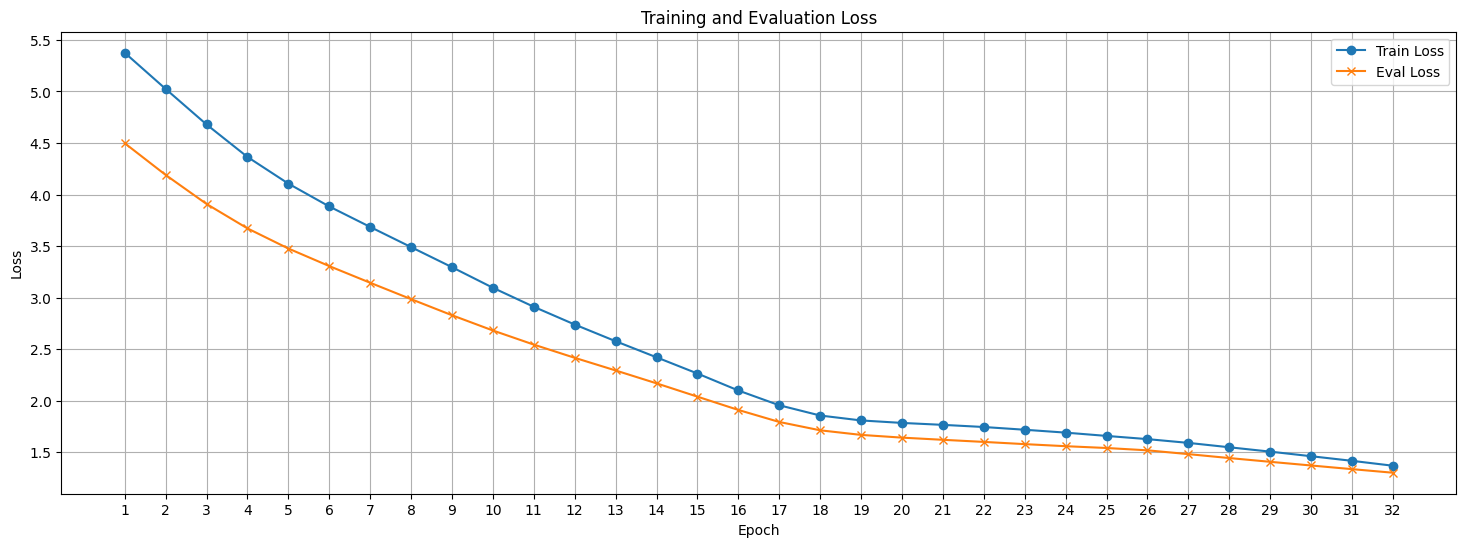

In [9]:
# 訓練配置
epochs = 32
lr = 5e-5
batch_size = 3
gradient_accumulation_steps = 2 if device == "cuda" else 1
print(f"歌詞訓練配置:")
print(f"  • 訓練輪數: {epochs}")
print(f"  • 學習率: {lr}")
print(f"  • 批次大小: {batch_size}")
print(f"  • 梯度累積: {gradient_accumulation_steps} 步")
print(f"  • 有效批次: {batch_size * gradient_accumulation_steps}")


start_time = datetime.now()
print("開始歌詞創作 AI 訓練...")
print(f"訓練開始時間: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# 開始訓練
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size)
history = train(
    model=peft_model,
    train_loader=train_loader,
    eval_loader=eval_loader,
    lr=lr,
    epochs=epochs,
    gradient_accumulation_steps=gradient_accumulation_steps
)

# 訓練完成
end_time = datetime.now()
training_duration = end_time - start_time
print("\n歌詞創作模型訓練完成！")
print(f"總訓練時間: {training_duration}")
print(f"完成時間: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")


# 繪製訓練歷史
import matplotlib.pyplot as plt
def plot_training_history(history: list[dict]):
    epochs = [h["epoch"] for h in history]
    train_losses = [h["train_loss"] for h in history]
    eval_losses = [h["eval_loss"] for h in history]

    plt.figure(figsize=(18, 6))
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, eval_losses, label="Eval Loss", marker='x')
    plt.title("Training and Evaluation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.legend()
    plt.grid()
    plt.show()
plot_training_history(history)


## 10. 存儲微調好的模型

In [10]:
# 保存最終模型
print("\n保存歌詞創作模型...")
save_lora_path = "./output/lyrics_lora"
peft_model.save_pretrained(save_lora_path)
print(f"歌詞創作模型已保存至: {save_lora_path}")

# 釋放 GPU 記憶體
import gc
del model, peft_model
gc.collect()
torch.cuda.empty_cache() if device == "cuda" else None


保存歌詞創作模型...
歌詞創作模型已保存至: ./output/lyrics_lora


## 11. 載入微調好的模型

In [11]:
# 載入分詞器
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side="right")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 載入模型
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, **model_kwargs)
peft_model = PeftModel.from_pretrained(model, save_lora_path, is_trainable=True)


## 12. 測試訓練後的 AI 歌詞創作效果！

In [12]:
# 測試生成歌詞功能
test_generate_lyrics(lambda prompt: generate_lyrics(peft_model, tokenizer, prompt))



開始測試歌詞生成...

測試 1: 創作一首關於宇宙探索的科幻風格歌詞
----------------------------------------------------------------------
生成歌詞:
好的，以下是一首關於宇宙探索的科幻風格歌詞：

(Intro - 鋼琴旋律，漸漸加入電子音效)

(Verse 1)
星塵漂浮，寂靜的黑夜
遠方恆星，光芒在流逝
心跳加速，引擎低吼
我們飛行，追尋未知的旅程

(Pre-Chorus)
時間是謊言，空間是夢幻
我們是星際探險的先鋒
未知的星系，等待著發現
我們將迎接，宇宙的奇蹟

(Chorus - 鼓聲、合成器加入)
星河的呼喚，響徹宇宙
穿透星雲，尋找新的光
無垠的空間，我們將去探索
宇宙的秘密，等待我們揭開

(Verse 2)
殖民地建立，在月球之上
水資源收集，在火星土壤
星際穿梭，穿越星際海
尋找生命，在古老的星系

(Pre-Chorus)
時間是謊言，空間是夢幻
我們是星際探險的先鋒
未知的星系，等待著發現
我們將迎接，宇宙的奇蹟

(Chorus - 鼓聲、合成器加入)
星河的呼喚，響徹宇宙
穿透星雲，尋找新的光
無垠的空間，我們將去探索
宇宙的秘密，等待我們揭開

(Bridge - 鋼琴旋律，加入低沉的合成器)
或許我們只是微不足道的一粒塵
但我們的心，渴望著無限的夢想
探索宇宙的奧秘，是我們存在的意義
在
----------------------------------------------------------------------
生成下一首歌詞...

測試 2: 寫一首關於程式設計師的幽默搖滾歌詞
----------------------------------------------------------------------
生成歌詞:
好的，以下是一首關於程式設計師的幽默搖滾歌曲歌詞：

(開場：快速的吉他 riff，和弦流動)

(Verse 1)
凌晨三點，咖啡杯裡滿滿的
螢幕閃爍，像黑洞一樣
我還在加班，編碼的夢想
解決一個bug，就像破解密碼

(Pre-Chorus)
我是一個程式設計師，不是愛好者
我只在邏輯裡生活
我喜歡在線上，在一個無盡的數字世界中
這就是我的舒適區

(Chorus)
我們是程式設計師，我們是技術奇蹟


## 13. 創建 Gradio Web UI 互動介面

In [ ]:
def get_random_prompt():
    """獲取隨機歌詞主題"""
    random_prompts = [
        "午夜的咖啡店",
        "追逐夢想的年輕人", 
        "下雨天的回憶",
        "城市的霓虹燈",
        "老朋友的重逢",
        "星空下的許願",
        "畢業季的離別",
        "第一次戀愛",
        "家鄉的味道",
        "克服困難的勇氣"
    ]
    return f"寫一首關於{random.choice(random_prompts)}的歌詞"

# 創建 Gradio 介面
print("創建歌詞創作 Web UI...")

# 定義介面組件
with gr.Blocks(title="🎵 AI 歌詞創作大師", theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # 🎵 AI 歌詞創作大師
        
        使用 LoRA 微調的 Gemma-3-1B-IT 模型，為您創作各種風格的原創歌詞！
        支援多種音樂風格和情感表達，讓創意無限延伸。
        
        ✨ **特色功能**:
        - 🎶 多種音樂風格 (流行、搖滾、民謠、說唱、古風、爵士)
        - 💝 豐富情感表達 (浪漫、勵志、治癒、懷舊等)
        - 🎲 隨機主題靈感
        """
    )
    
    with gr.Row():
        with gr.Column(scale=2):
            # 主要輸入區域
            prompt_input = gr.Textbox(
                label="🎼 歌詞主題",
                placeholder="輸入您想要的歌詞主題，例如：'關於友情的故事'、'失戀後的成長'等",
                lines=2,
                value=""
            )
            
            # 按鈕區域
            with gr.Row():
                generate_btn = gr.Button(
                    "🎵 創作歌詞", 
                    variant="primary",
                    size="lg"
                )
                
                random_btn = gr.Button(
                    "🎲 隨機主題",
                    size="lg"
                )
        
        with gr.Column(scale=3):
            # 輸出區域
            output_text = gr.Textbox(
                label="🎼 生成的歌詞",
                lines=20,
                max_lines=25,
                show_copy_button=True,
                container=True
            )
    
    # 綁定事件
    generate_btn.click(
        fn=lambda prompt: generate_lyrics(peft_model, tokenizer, prompt),
        inputs=[prompt_input],
        outputs=output_text,
        show_progress=True
    )
    
    random_btn.click(
        fn=get_random_prompt,
        outputs=prompt_input,
        show_progress=False
    )

print("Gradio Web UI 創建完成！")
demo.launch(
    share=True,  # 創建公開分享連結
)


創建歌詞創作 Web UI...
Gradio Web UI 創建完成！
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://606654e0bee27683f9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
